# Activity Profiles

In [57]:
from math import floor, ceil

from itertools import chain

import seaborn as sns

## Config

In [15]:
sns.set()

In [2]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

## Load target list

Load the list of the targets of interest.


* Targets are defined in terms of symbol/species pairs.


* Only Human targets are being considered at this stage.


* Only targets with a minimum of 40 actives are considered.


* Active compounds are defined in terms of USMILES.


* See notebook '[10_Get_actives_and_mols](10_Get_actives_and_mols.ipynb)' for further details of the file'`actives.pkl`.

In [25]:
# Reload active mols...

actives, active_mols = pickle.load(open('actives.pkl'))

In [26]:
symbols = actives['symbol'].unique().tolist()

len(symbols)

138

## Get pActivity data for targets of interest

In [4]:
def get_means(df):
    
    means = df[['symbol', 'usmiles', 'pchembl_value']].groupby(['symbol', 'usmiles']).mean().reset_index(level=1)

    logging.info("No. rows: {}; min. pActivity: {:.2f}; max. pActivity: {:.2f}".format(means.shape[0], means['pchembl_value'].min(), means['pchembl_value'].max()))
    
    return means

### All pActivity data

In [5]:
data0 = pd.read_sql("""
    select
          a.symbol
        , b.usmiles
        , a.parent_cmpd_chemblid as cmpd
        , a.pchembl_value
        , a.active
    from
        tt_curve_data_v1 a
        join tt_structure_lookup b on a.parent_cmpd_chemblid = b.cmpd
    where
        a.species = 'Human'
    and a.exclude = 0
    and a.nat >= 10
    and a.nat <= 50
    and a.symbol in ({})
""".format(', '.join("'{}'".format(x) for x in symbols)), engine)

data0.shape

(289568, 5)

In [6]:
means0 = get_means(data0)

[2015/Aug/13 11:38:12 INFO    ] No. rows: 207918; min. pActivity: 2.30; max. pActivity: 11.00


In [7]:
subset0 = data0.query("symbol == 'MAPK1'")

subset0.shape

(14265, 5)

In [8]:
subset1 = get_means(subset0)

[2015/Aug/13 11:38:12 INFO    ] No. rows: 13623; min. pActivity: 2.30; max. pActivity: 9.69


### Only for 'active' compounds

In [9]:
data1 = pd.read_sql("""
select
    a.symbol
  , c.usmiles
  , a.parent_cmpd_chemblid as cmpd
  , a.pchembl_value
  , a.active
from
  tt_curve_data_v1 a
  join tt_structure_lookup b on a.parent_cmpd_chemblid = b.cmpd
  join tt_curve_data_actives_subset c on a.symbol = c.symbol and b.usmiles = c.usmiles
where
    a.species = 'Human'
and a.exclude = 0
and a.nat >= 10
and a.nat <= 50
""".format(', '.join("'{}'".format(x) for x in symbols)), engine)

data1.shape

(239468, 5)

In [10]:
means1 = get_means(data1)

[2015/Aug/13 11:38:23 INFO    ] No. rows: 167055; min. pActivity: 4.34; max. pActivity: 11.00


## Plot activity histograms

In [34]:
ncols = 3

xsize, ysize = 6, 4

xmin, xmax = 4, 10

bin_width = 0.25

def do_plots(df, symbols=None):
        
    if symbols is None: symbols = df.index.drop_duplicates().tolist()

    nrows = int(ceil(len(symbols) / ncols))

    # xmin, xmax = floor(df['pchembl_value'].min()), ceil(df['pchembl_value'].max())

    bins = np.arange(xmin, xmax + bin_width, bin_width)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    fig.set_size_inches(ncols * xsize, nrows * ysize)

    for axis, symbol in zip(axes.flat, symbols):
                
        x = df.loc[symbol, 'pchembl_value'].tolist()

        axis.hist(x, bins=bins, normed=1, histtype='bar')

        axis.set_xlim(xmin, xmax)

        axis.set_xticks(bins)

        axis.set_xticklabels(bins, rotation=45)

        axis.set_title("{} ({})".format(symbol, len(x)))
        
        axis.axvline(x=5, color='r', linestyle='-', linewidth=2)
        
    plt.tight_layout()
    
    for axis in axes.flat[len(symbols):]: axis.set_visible(False) # Hide surplus plots
            
    return None

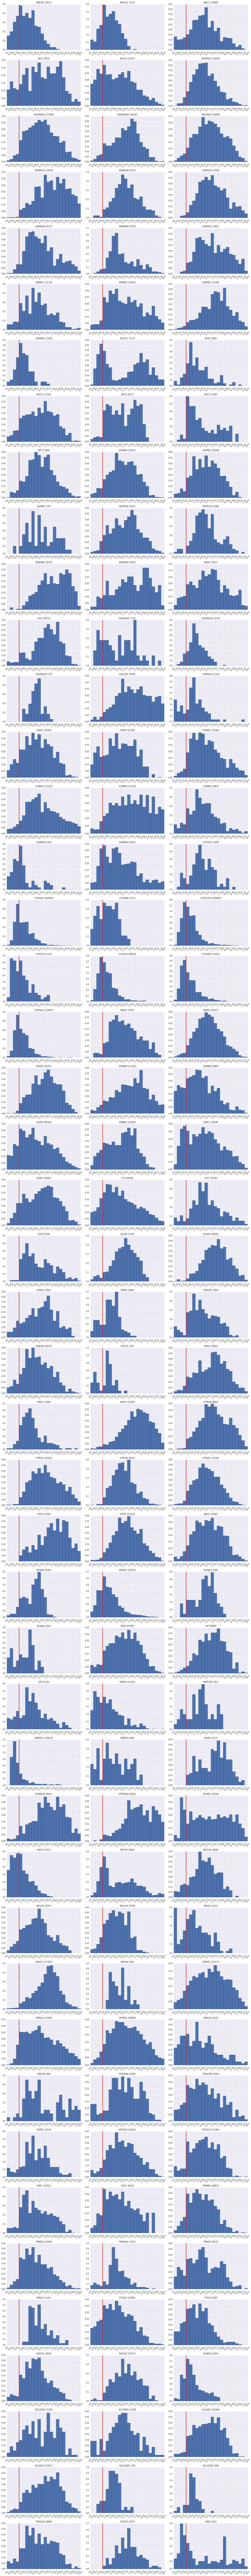

In [20]:
# All pActivity data for targets of interest...

_ = do_plots(means0)

In [23]:
# pActivity data for 'active' compounds and targets of interest...

# _ = do_plots(means1)

In [50]:
classes = pd.read_pickle('target_class_map.pkl').merge(actives.groupby('symbol').apply(len).to_frame('N'), left_index=True, right_index=True).sort().reset_index(drop=False)

In [101]:
classes.target_class.unique().tolist()

['Transporter > Primary active transporter',
 'Enzyme > Kinase > Protein Kinase',
 'Enzyme',
 'Membrane receptor > G protein-coupled receptor',
 'Transcription factor',
 'Ion channel > Voltage-gated ion channel',
 'Ion channel > Ligand-gated ion channel',
 'Enzyme > Cytochrome P450',
 'Enzyme > Phase II',
 'Enzyme > Kinase > PI3 Kinase',
 'Transporter > Electrochemical transporter']

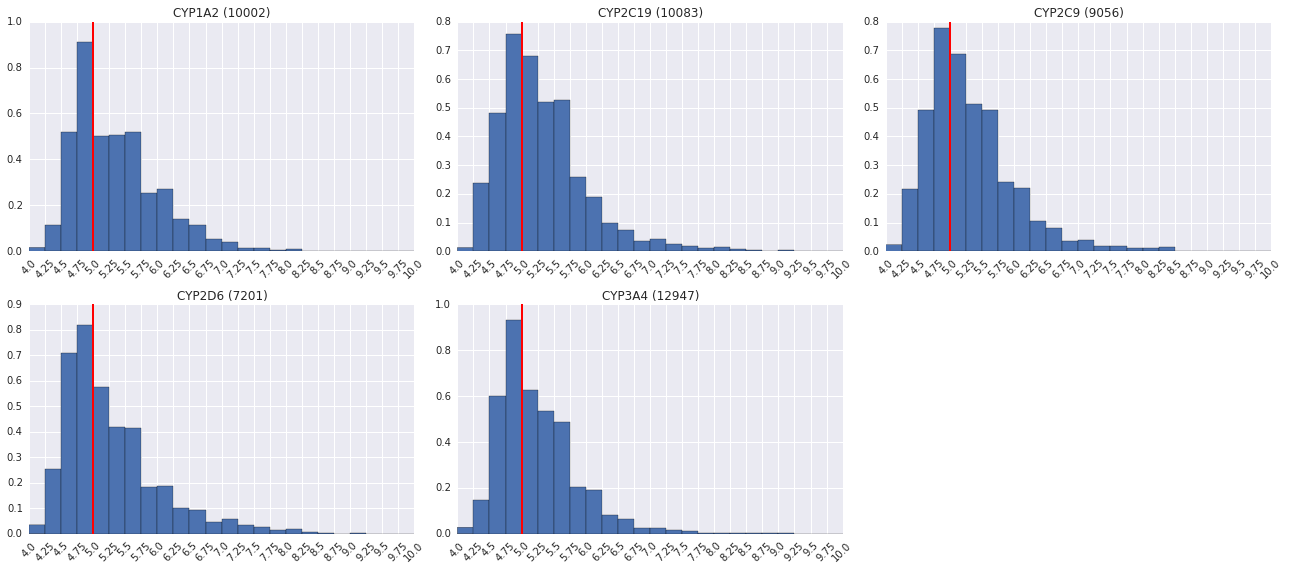

In [51]:
target_class = 'Enzyme > Cytochrome P450'

symbols = classes.query("target_class == @target_class and N > 100")['symbol']

_ = do_plots(means0, symbols)

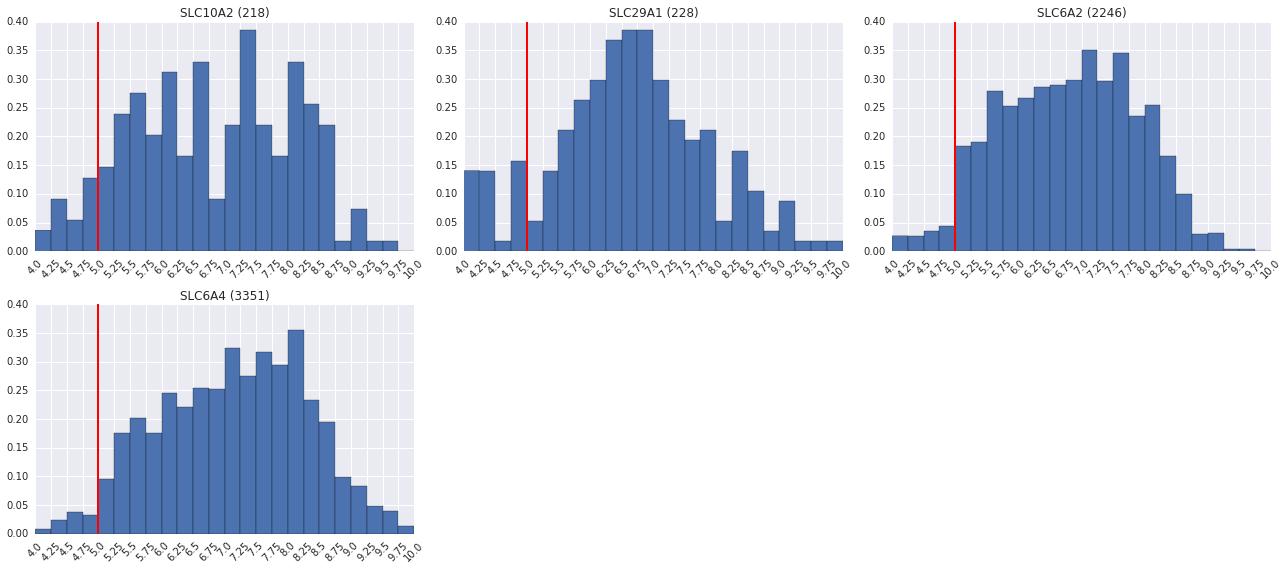

In [99]:
target_class = 'Transporter > Electrochemical transporter'

symbols = classes.query("target_class == @target_class and N > 100")['symbol']

_ = do_plots(means0, symbols)

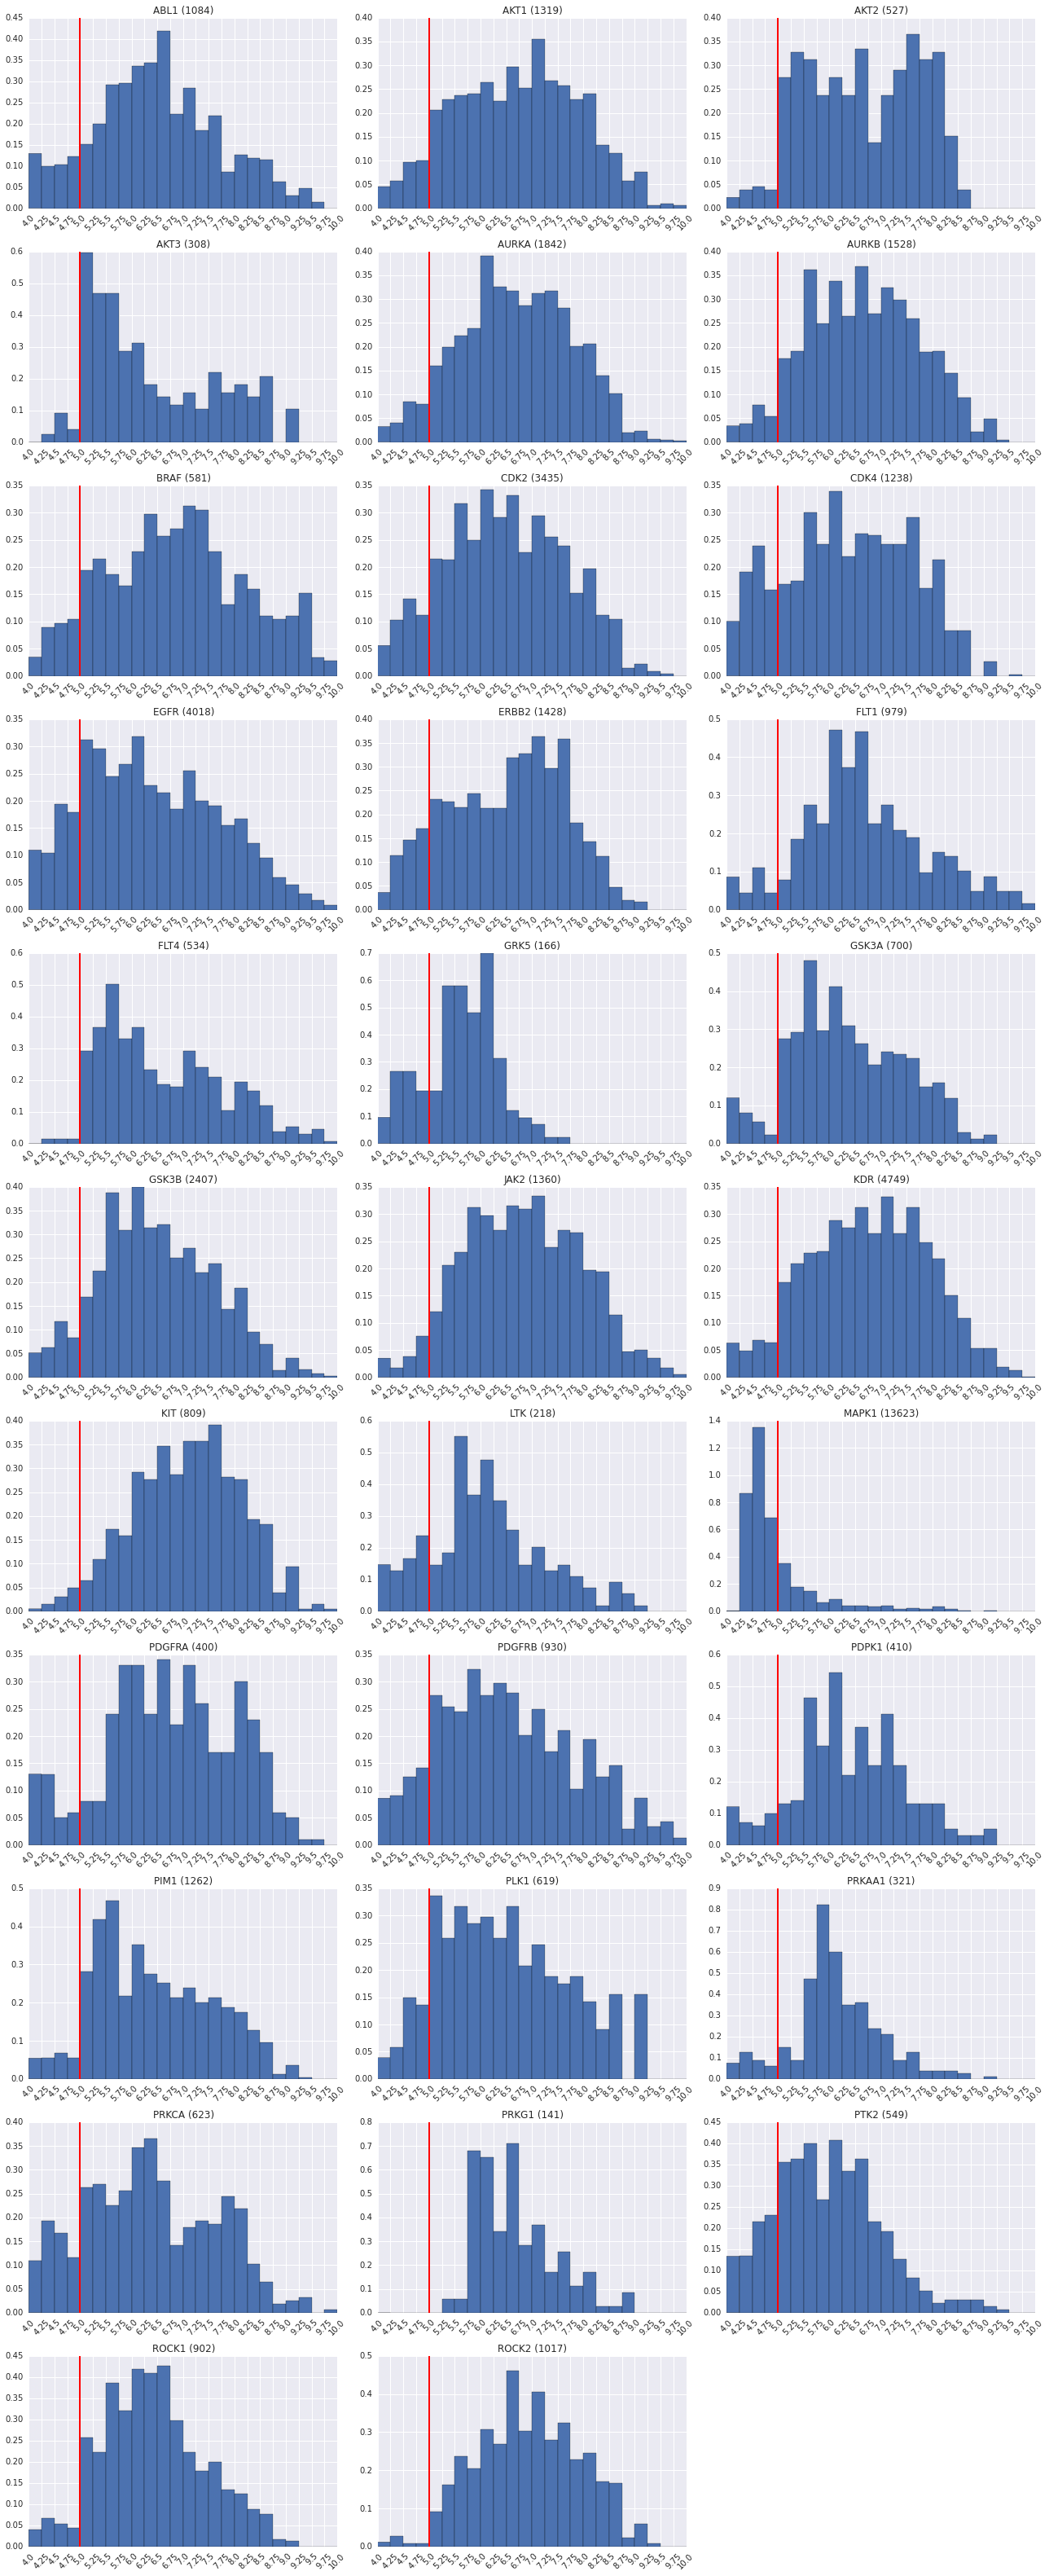

In [102]:
target_class = 'Enzyme > Kinase > Protein Kinase'

symbols = classes.query("target_class == @target_class and N > 100")['symbol']

_ = do_plots(means0, symbols)

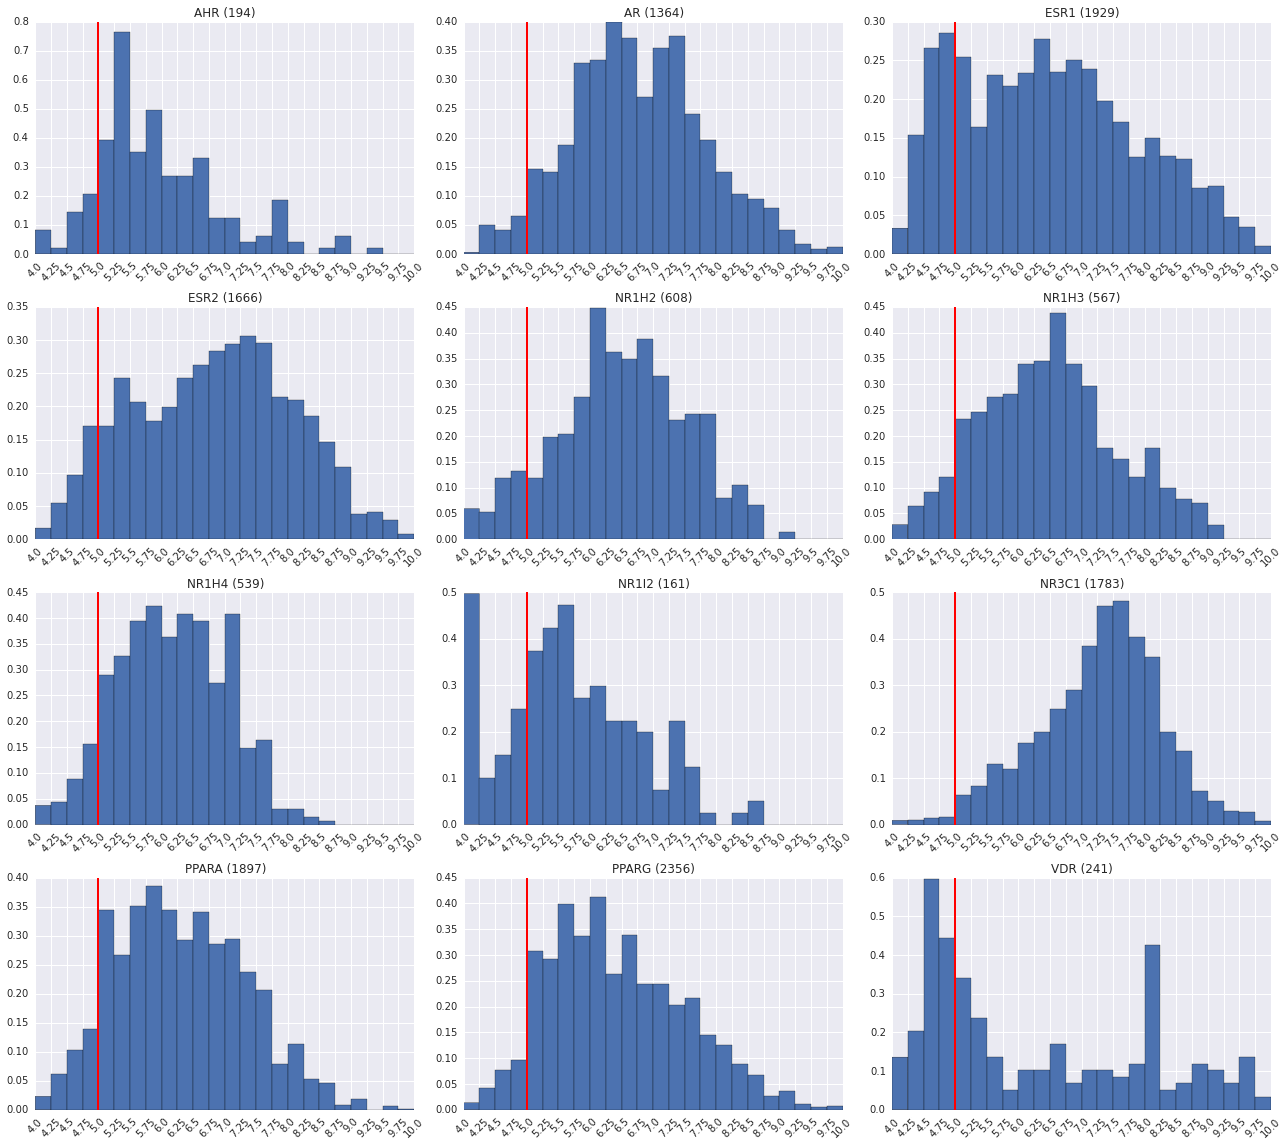

In [103]:
target_class = 'Transcription factor'

symbols = classes.query("target_class == @target_class and N > 100")['symbol']

_ = do_plots(means0, symbols)

In [89]:
medians1 = means0.groupby(level=0).median().merge(classes, left_index=True, right_on='symbol')

medians2 = means0.merge(classes, left_index=True, right_on='symbol').groupby('target_class').median().reset_index(drop=False)

In [94]:
def get_color_map(n_classes):

    n = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('gist_rainbow')(np.linspace(0.0, 1.0, n))

    return color_map[list(chain.from_iterable(zip(range(0, int(n/2)), range(int(n/2), n))))[:n_classes]] # Return number requested

def do_plot(df, col, xlabelcol='symbol'):
    
    df = df.sort('target_class').copy()

    # Colour mapping...

    classes = df['target_class'].unique().tolist()

    class_numbers = [classes.index(x) for x in df['target_class']]

    color_map = get_color_map(len(classes))

    # Create Plot

    fig, ax = plt.subplots()

    fig.set_size_inches(40, 10)

    x_positions = range(df.shape[0])
    
    x_values = df[col].tolist()
    
    bars = ax.bar(x_positions, x_values, width=0.9, align='center', color=[color_map[x] for x in class_numbers])

    ax.set_xlim([x_positions[0]-0.5, x_positions[-1]+0.5])

    ax.set_xticks(x_positions)

    ax.tick_params(axis='both', direction='out')

    ax.set_xticklabels(df[xlabelcol].tolist(), rotation=45, ha='right', fontsize=8)

    ax.legend([bars[class_numbers.index(x)] for x in range(len(classes))], classes, fontsize=16, bbox_to_anchor=(1.21, 1.00))
    
    plt.show()

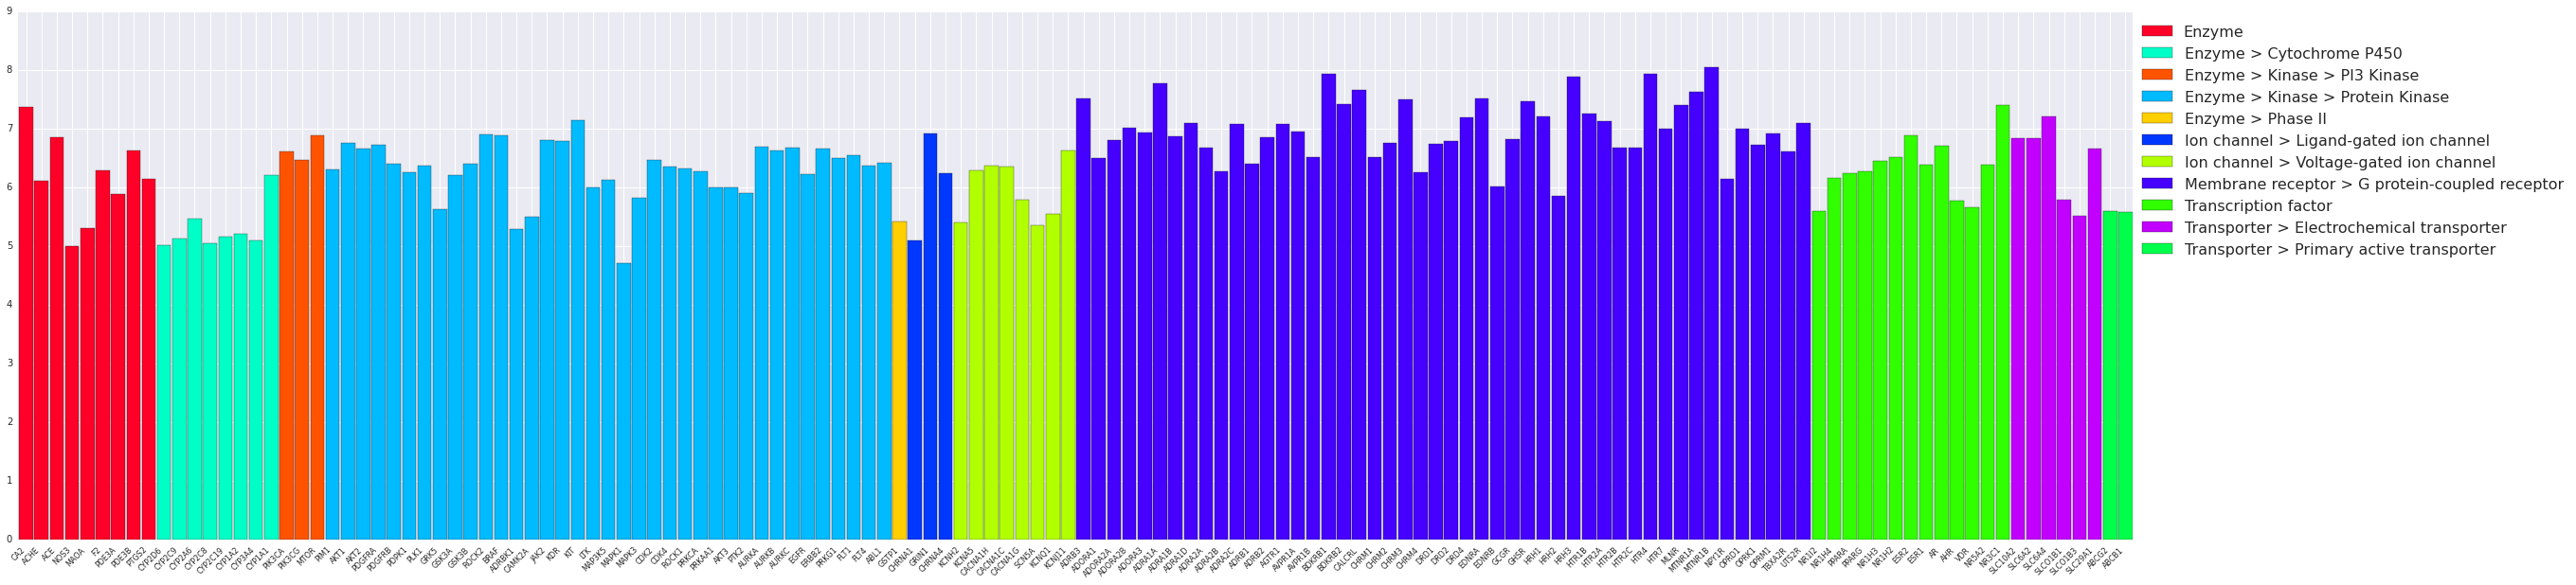

In [95]:
do_plot(medians1, 'pchembl_value')

In [97]:
medians2.sort('pchembl_value')

,target_class,pchembl_value,N
1,Enzyme > Cytochrome P450,5.1000,6140
4,Enzyme > Phase II,5.4200,40
6,Ion channel > Voltage-gated ion channel,5.5000,3686
10,Transporter > Primary active transporter,5.5700,652
3,Enzyme > Kinase > Protein Kinase,6.0000,3087
5,Ion channel > Ligand-gated ion channel,6.2900,750
0,Enzyme,6.4325,3549
8,Transcription factor,6.5700,1574
2,Enzyme > Kinase > PI3 Kinase,6.6200,1307
7,Membrane receptor > G protein-coupled receptor,6.9650,1664


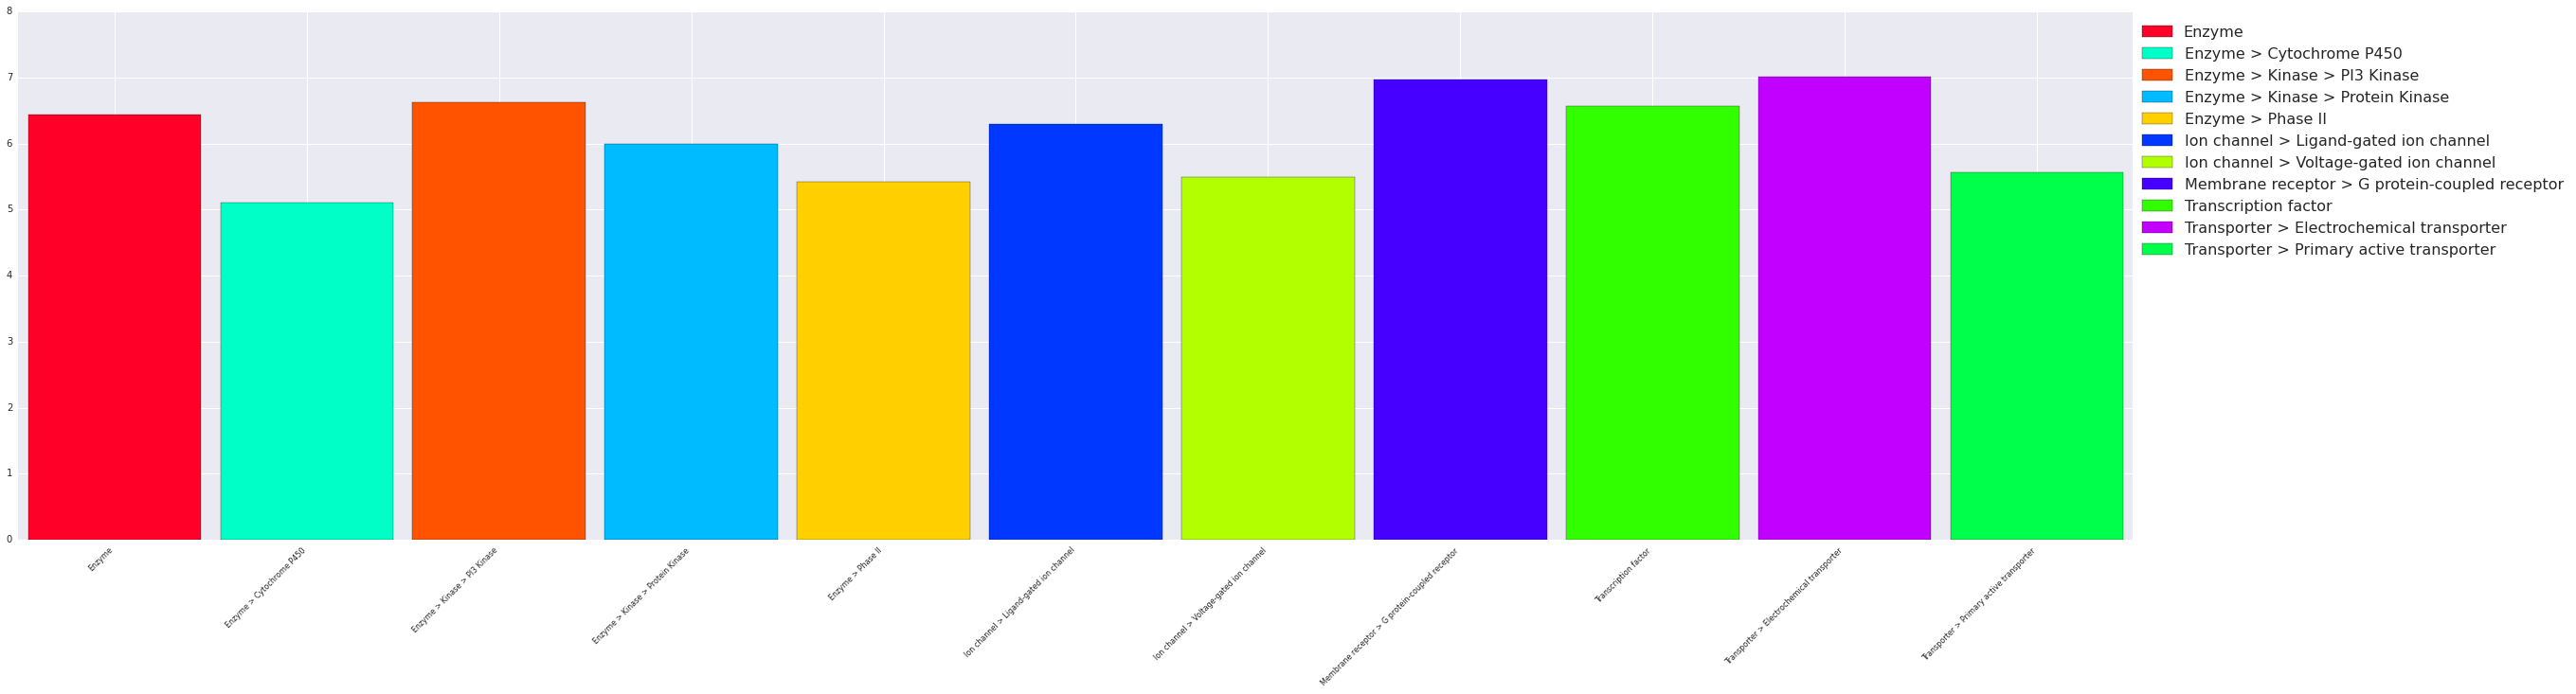

In [96]:
do_plot(medians2, 'pchembl_value', xlabelcol='target_class')